# Getting started with the Monitoring API

Cloud Datalab provides an environment for working with your data. This includes data that is being managed within the Monitoring API. This notebook introduces some of the APIs that Cloud Datalab provides for working with the monitoring data, and allows you to try them out on your own project.

The main focus of this API is to allow you to query timeseries data for your monitored resources. There are also commands to help you list the available metrics and resource types.

## Importing the API

In [1]:
from gcp.stackdriver import monitoring as gcm

## List names of Compute Engine CPU metrics

Here we can see that `instance_name` is a metric label.

In [89]:
%%monitoring list metrics --type compute*/cpu/*

Metric type,Kind,Value,Labels
compute.googleapis.com/instance/cpu/reserved_cores,GAUGE,DOUBLE,instance_name
compute.googleapis.com/instance/cpu/usage_time,DELTA,DOUBLE,instance_name
compute.googleapis.com/instance/cpu/utilization,GAUGE,DOUBLE,instance_name


## List monitored resource types related to GCE

In [88]:
%%monitoring list resource_types --type gce*

Resource type,Labels
gce_disk,"project_id, disk_id, zone"
gce_instance,"project_id, instance_id, zone"


## Querying timeseries data

The `gcm.Query` class allows users to query and access the monitoring timeseries data. The results of the query can be accessed as a pandas `DataFrame` object. This is a widely used library for data manipulation.

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

### Initializing the query

During intialization, the metric type and the time interval need to be specified. For interactive use, the metric type has a default value. The simplest way to specify the time interval that ends `now` is to use the arguments `days`, `hours`, and `minutes`.

In [85]:
q = gcm.Query('compute.googleapis.com/instance/cpu/utilization', hours=2)

### Getting the metadata

The method `labels_as_dataframe()` allows you to look at the labels for the given metric, and the values that exist.

This helps you understand the structure of the timeseries data, and makes it easier to modify the query.

In [60]:
q.labels_as_dataframe()

resource     resource.labels                                      \
           type          project_id           zone          instance_id   
0  gce_instance  monitoring-datalab  us-central1-b  2292393497529867090   
1  gce_instance  monitoring-datalab     us-east1-d  5437900963820317613   

           metric.labels  
           instance_name  
0  gae-datalab-main-j642  
1               analyst2

### Filtering the query

Here, we filter the query to instances whose names begin with `'gae-'`. These are instances which host `Cloud Datlab`.

**Note**: If running locally, you may need to replace 'gae-' by the name of an instance in your project.
You can find the name of instances in your project in the last column of the results from `labels_as_dataframe` above.

In [53]:
# Filter the query to instances with the specified prefix.
q1 = q.select_metrics(instance_name_prefix='gae-')

# If you know the exact name of the instance, you can also use:
# q1 = q.select_metrics(instance_name='<INSTANCE NAME')

# Get the query results as a pandas DataFrame and look at the last 5 rows.
df1 = q1.as_dataframe(label='instance_name')
df1.tail(5)

,gae-datalab-main-j642
2016-04-07 18:07:01.763,0.042580
2016-04-07 18:08:01.763,0.045067
2016-04-07 18:09:01.763,0.041776
2016-04-07 18:10:01.763,0.053421
2016-04-07 18:11:01.763,0.075612


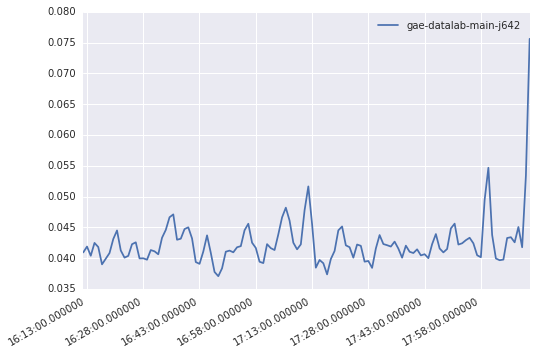

In [82]:
# N.B. A useful trick is to assign the return value of plot to _ 
# so that you don't get text printed before the plot itself.

_ = df1.plot()

### Aligning the query

For multiple timeseries, aligning the data is recommended. The alignment offset can be specified using the arguments `hours`, `minutes`, and `seconds`.

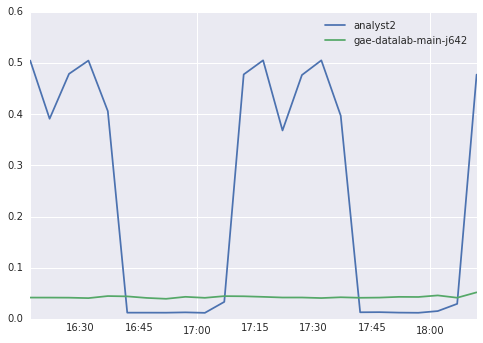

In [55]:
# Align the query to have data every 5 minutes.
q2 = q.align('ALIGN_MEAN', minutes=5)

df2 = q2.as_dataframe(label='instance_name')
_ = df2.plot()

### Displaying the results as a heatmap

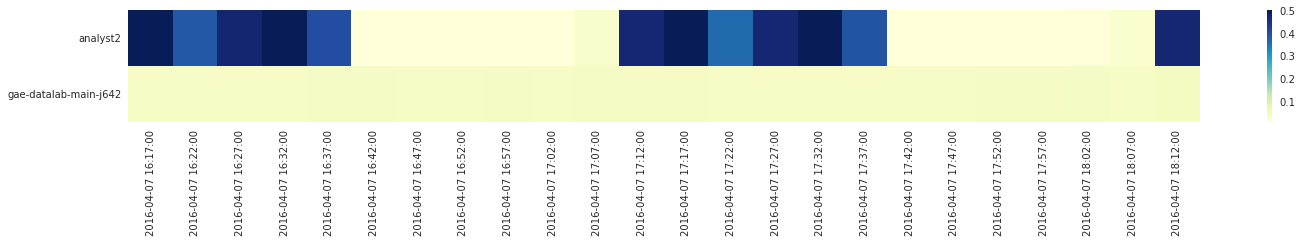

In [87]:
import matplotlib
import seaborn

# Set the size of the heatmap to have a better aspect ratio.
matplotlib.pyplot.figure(figsize=df2.shape)
_ = seaborn.heatmap(df2.T, xticklabels=df2.index.map(str), cmap='YlGnBu')

### Reducing the query

In order to aggregate the timeseries data, the `reduce()` method can be used. The fields to be retained after aggregation must be specified in the method.

For example, to aggregate the results by the zone, `'resource.zone'` can be specified.

In [56]:
q3 = q2.reduce('REDUCE_MEAN', 'resource.zone')
df3 = q3.as_dataframe('zone')
df3.tail(5)

,us-central1-b,us-east1-d
2016-04-07 17:52:00,0.042896,0.012093
2016-04-07 17:57:00,0.042662,0.011775
2016-04-07 18:02:00,0.045716,0.015109
2016-04-07 18:07:00,0.041220,0.029259
2016-04-07 18:12:00,0.051691,0.477413


## Multi-level headers

If you don't provide any labels to `as_dataframe`, it returns all the resource and metric labels present in the timeseries as a multi-level header.

This allows you to filter, and aggregate the data more easily.

In [71]:
multi_level_df = q2.as_dataframe()
multi_level_df.tail(5)

resource_type                gce_instance                    
project_id             monitoring-datalab                    
zone                        us-central1-b          us-east1-d
instance_id           2292393497529867090 5437900963820317613
instance_name       gae-datalab-main-j642            analyst2
2016-04-07 17:52:00              0.042896            0.012093
2016-04-07 17:57:00              0.042662            0.011775
2016-04-07 18:02:00              0.045716            0.015109
2016-04-07 18:07:00              0.041220            0.029259
2016-04-07 18:12:00              0.051691            0.477413

### Filter the dataframe

In [84]:
multi_level_df.filter(regex='gae-datalab-main').tail(5)

resource_type,gce_instance
project_id,monitoring-datalab
zone,us-central1-b
instance_id,2292393497529867090
instance_name,gae-datalab-main-j642
2016-04-07 17:52:00,0.042896
2016-04-07 17:57:00,0.042662
2016-04-07 18:02:00,0.045716
2016-04-07 18:07:00,0.041220
2016-04-07 18:12:00,0.051691


### Aggregate columns in the datframe

In [76]:
multi_level_df.groupby(level='zone', axis=1).mean().tail(5)

zone,us-central1-b,us-east1-d
2016-04-07 17:52:00,0.042896,0.012093
2016-04-07 17:57:00,0.042662,0.011775
2016-04-07 18:02:00,0.045716,0.015109
2016-04-07 18:07:00,0.041220,0.029259
2016-04-07 18:12:00,0.051691,0.477413
